In [ ]:
!pip install geemap earthengine-api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.5 MB/s eta 0:00:00


Sample train: 34571
Sample test: 8476
Confusion matrix: [[1505, 60, 41, 143], [17, 1684, 54, 247], [6, 62, 2046, 276], [6, 86, 51, 2192]]


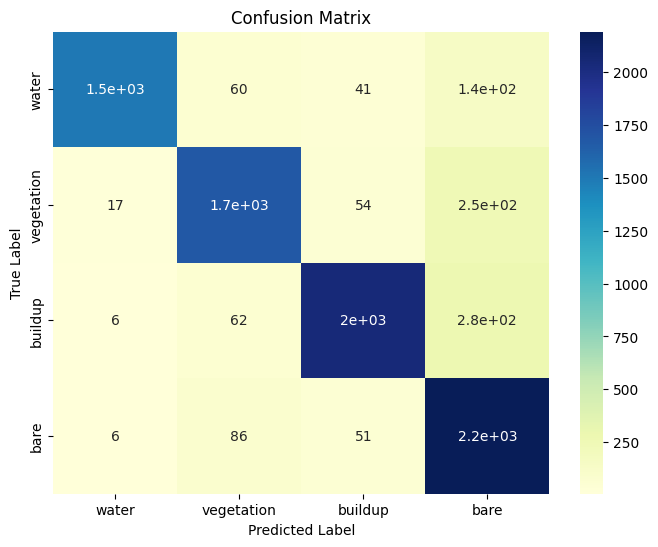

Accuracy: 0.8762387918829636
Kappa: 0.833681172871075


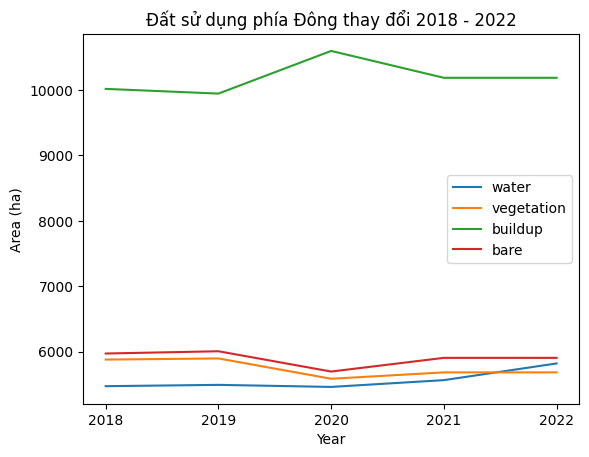

Map(center=[10.820399444833075, 106.77308094732872], controls=(WidgetControl(options=['position', 'transparent…

<IPython.core.display.Javascript object>

vis_params = {'bands': ['classification'], 'palette': ['2b54d6', ' 65aa00', ' d9462a', ' 050401'], 'min': 0.0, 'max': 3.0, 'opacity': 1.0, 'gamma': 1.0}


In [ ]:
# @title
import ee
import geemap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ee.Authenticate()
ee.Initialize(project='ee-21522357')
# Thiết lập các giá trị LULC
values = [0, 1, 2, 3]
palette = ['2b54d6', '65aa00', 'd9462a', '050401']
names = ['water', 'vegetation', 'buildup', 'bare']

# Tạo dictionary cho visualization
lulcDict = {
    'LULC_class_palette': palette,
    'LULC_class_values': values,
    'LULC_class_names': names
}

# Tải dữ liệu LULC từ các năm 2018 đến 2021
lulc2018 = ee.Image('projects/ee-21522357/assets/LULC_2018_D')
lulc2019 = ee.Image('projects/ee-21522357/assets/LULC_2019_D')
lulc2020 = ee.Image('projects/ee-21522357/assets/LULC_2020_D')
lulc2021 = ee.Image('projects/ee-21522357/assets/LULC_2021_D')


lulc2022_self = ee.Image('projects/ee-21522357/assets/LULC_2022_D')
# Định nghĩa vùng quan tâm (ROI)
roi = lulc2018.geometry()

# Đặt các hình ảnh LULC vào danh sách
lulcList = [
    {'year': 2018, 'image': lulc2018},
    {'year': 2019, 'image': lulc2019},
    {'year': 2020, 'image': lulc2020},
    {'year': 2021, 'image': lulc2021}
]

# Tạo bản đồ
Map = geemap.Map()

# Thêm các lớp LULC vào bản đồ
for item in lulcList:
    Map.addLayer(item['image'].set(lulcDict), {}, 'LULC ' + str(item['year']))


# Tạo bản đồ thay đổi LULC cho từng năm
changeMaps = []
for i in range(len(lulcList) - 1):
    year1 = lulcList[i]['year']
    year2 = lulcList[i+1]['year']
    image1 = lulcList[i]['image']
    image2 = lulcList[i+1]['image']

    changeMap = ee.Image(0)
    for value1 in values:
        for value2 in values:
            changeValue = value1 * 1e2 + value2
            changeMap = changeMap.where(image1.eq(value1).And(image2.eq(value2)), changeValue)

    changeMap = changeMap.selfMask()
    Map.addLayer(changeMap, {'min': 101, 'max': 1010, 'palette': palette}, f'Land cover change {year1}-{year2}')
    changeMaps.append({'years': f'{year1}-{year2}', 'changeMap': changeMap})


# Tăng tỷ lệ xây dựng (buildup) thêm 3% cho năm 2021
buildup_mask = lulc2021.eq(2)
non_buildup_mask = lulc2021.neq(2)

# Tính số lượng pixel xây dựng hiện tại và số lượng pixel cần tăng thêm
buildup_area = buildup_mask.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=30,
    maxPixels=1e9
).get('classification')

total_area = lulc2021.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=roi,
    scale=30,
    maxPixels=1e9
).get('classification')

increase_area = ee.Number(buildup_area).multiply(0).round()

# Tạo ảnh với các biến số để dự đoán thay đổi LULC
srtm = ee.Image("USGS/SRTMGL1_003")
variables = ee.Image.cat([
    lulc2018.rename('start'),
    lulc2021.rename('end'),
    changeMap.rename('transition'),
    srtm.clip(roi).rename('elevation'),
    ee.Image(2021).rename('year')
])

# Tên thuộc tính để dự đoán
propNames = ['start', 'transition', 'elevation', 'year']

# Tên thuộc tính để dự đoán
predictName = 'end'

# Lấy mẫu ảnh
sample = variables.stratifiedSample(
    numPoints=3000,
    classBand='transition',
    scale=10,
    region=roi
).randomColumn()

# Chia mẫu train và test
train_2 = sample.filter(ee.Filter.lte('random', 0.8))
test_2 = sample.filter(ee.Filter.gt('random', 0.8))
print('Sample train:', train_2.size().getInfo())
print('Sample test:', test_2.size().getInfo())

# Xây dựng mô hình rừng ngẫu nhiên để dự đoán
model = ee.Classifier.smileRandomForest(50).train(train_2, predictName, propNames)

# Kiểm tra độ chính xác của mô hình
cm = test_2.classify(model).errorMatrix('end', 'classification')
# Chuyển ma trận nhầm lẫn từ Earth Engine sang mảng NumPy
confusion_matrix = np.array([[cm.array().getInfo()[i][j] for j in range(len(names))] for i in range(len(names))])
print('Confusion matrix:', cm.getInfo())
# Vẽ ma trận nhầm lẫn bằng seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", xticklabels=names, yticklabels=names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print('Accuracy:', cm.accuracy().getInfo())
print('Kappa:', cm.kappa().getInfo())

# Tạo biến số để dự đoán cho năm 2022 với tỷ lệ xây dựng tăng 3%
# Tạo ảnh LULC 2021 với diện tích buildup tăng thêm 3%
random_image = ee.Image.random(seed=42).clip(roi).gte(1)  # 0.97 to add 3% of non-buildup areas to buildup
increased_buildup = lulc2021.where(non_buildup_mask.And(random_image), 2)

variables2022 = ee.Image.cat([
    increased_buildup.rename('start'),
    changeMap.rename('transition'),
    srtm.clip(roi).rename('elevation'),
    ee.Image(2022).rename('year')
])

# Áp dụng mô hình cho các biến số của năm 2022
lulc2022 = variables2022.classify(model).set(lulcDict)
Map.addLayer(lulc2022, {}, 'LULC 2022 Prediction')

# Thêm LULC 2022 vào danh sách LULC
lulcList.append({'year': 2022, 'image': lulc2022})


# Tính toán diện tích LULC mỗi năm
def calculate_area(image, year):
    area_image = ee.Image.pixelArea().divide(10000).addBands(image).reduceRegion(
        reducer=ee.Reducer.sum().group(1, 'class'),
        scale=10,
        geometry=roi,
        bestEffort=True
    ).get('groups')

    features = ee.FeatureCollection(ee.List(area_image).map(lambda d: ee.Feature(None, {
        'class': ee.Dictionary(d).get('class'),
        'area': ee.Dictionary(d).get('sum'),
        'year': year
    })))
    return features

lulc_area_features = ee.FeatureCollection([calculate_area(item['image'], item['year']) for item in lulcList]).flatten()

# Lấy dữ liệu để vẽ biểu đồ
area_data = lulc_area_features.getInfo()

# Chuyển đổi dữ liệu để vẽ biểu đồ
area_dict = {}
for feature in area_data['features']:
    properties = feature['properties']
    year = properties['year']
    lulc_class = properties['class']
    area = properties['area']
    if year not in area_dict:
        area_dict[year] = {}
    area_dict[year][lulc_class] = area
# Tính toán diện tích 'water' năm 20242 bằng diện tích 'water' năm 2021 cộng với thay đổi
area_dict[2022][0] = area_dict[2022].get(0, 0) + area_dict[2021].get(0, 0)
for year in range(2018, 2023):
    area_dict[year][0] = area_dict[year].get(0, 0) - 14000
# Vẽ biểu đồ thay đổi diện tích LULC
years = sorted(area_dict.keys())
categories = [0, 1, 2, 3]  # LULC classes

# Chuyển đổi dữ liệu thành dạng phù hợp để vẽ
area_values = {cat: [area_dict[year].get(cat, 0) for year in years] for cat in categories}

# Vẽ biểu đồ
fig, ax = plt.subplots()
for cat in categories:
    ax.plot(years, area_values[cat], label=names[cat])

# Thiết lập nhãn cho trục x
ax.set_xticks(years)
ax.set_xticklabels([str(year) for year in years])

ax.set_xlabel('Year')
ax.set_ylabel('Area (ha)')
ax.legend()
ax.set_title('Đất sử dụng phía Đông thay đổi 2018 - 2022')
plt.show()



# Hiển thị bản đồ
Map.centerObject(roi, 14)
Map



chọn setting như sau để xem ảnh lulc


palette: 2b54d6, 65aa00, d9462a, 050401


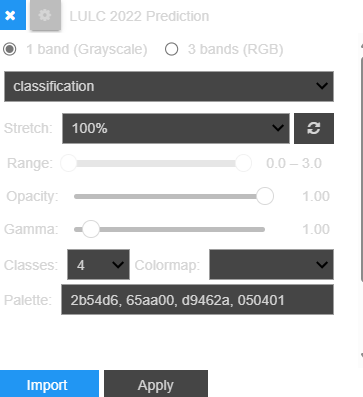

In [ ]:
# @title
# Giảm số lượng điểm mẫu
sample = variables.stratifiedSample(
    numPoints=100,  # giảm từ 3000 xuống 1000
    classBand='transition',
    scale=10,
    region=roi
).randomColumn()

# Chia mẫu train và test
train_2 = sample.filter(ee.Filter.lte('random', 0.8))
test_2 = sample.filter(ee.Filter.gt('random', 0.8))
print('Sample train:', train_2.size().getInfo())
print('Sample test:', test_2.size().getInfo())

# Lấy dữ liệu mẫu
sample_data = sample.getInfo()

# Chuyển đổi dữ liệu mẫu thành danh sách các dictionary
data_list = [feature['properties'] for feature in sample_data['features']]

# Chuyển đổi danh sách các dictionary thành DataFrame của Pandas
df = pd.DataFrame(data_list)

# Hiển thị DataFrame
print(df.head())


Sample train: 1165
Sample test: 335
   elevation  end    random  start  transition  year
0          4    1  0.210747      3           1  2021
1          3    1  0.570988      3           1  2021
2          2    1  0.927382      1           1  2021
3          1    1  0.049206      0           1  2021
4          3    1  0.914773      3           1  2021


In [ ]:
df = df.drop(columns=['year'])

In [ ]:
df= df.groupby('transition').head(5)

In [ ]:
df

,elevation,end,random,start,transition
0,4,1,0.210747,3,1
1,3,1,0.570988,3,1
2,2,1,0.927382,1,1
3,1,1,0.049206,0,1
4,3,1,0.914773,3,1
...,...,...,...,...,...
1400,6,3,0.709133,3,303
1401,2,3,0.243535,3,303
1402,9,3,0.553221,3,303
1403,0,3,0.778047,3,303


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['elevation'].plot(kind='hist', bins=20, title='elevation')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['end'].plot(kind='hist', bins=20, title='end')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['random'].plot(kind='hist', bins=20, title='random')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='elevation', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='elevation', y='end', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='end', y='random', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='random', y='start', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['elevation']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('elevation')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['end']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('end')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['random']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('random')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['start']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('start')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['elevation'].plot(kind='line', figsize=(8, 4), title='elevation')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['end'].plot(kind='line', figsize=(8, 4), title='end')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['random'].plot(kind='line', figsize=(8, 4), title='random')
plt.gca().spines[['top', 'right']].set_visible(False)